In [37]:
# xarray to read NETCDF
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
CanESM5 = xr.open_mfdataset('data/NMME/CanESM5/*.nc')
chirps = xr.open_dataset('data/CHIRPS/chirps-v2.0.monthly.nc')

In [39]:
CanESM5_south_sudan = (CanESM5.sel(Y=slice(3.5, 12.5), X=slice(205, 215))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'})
                       .groupby(['latitude', 'longitude', 'date of prediction', 'lead time'])
                       .mean('M'))
CanESM5_south_sudan['longitude'] = CanESM5_south_sudan['longitude'] - 180
CanESM5_south_sudan_df = CanESM5_south_sudan.to_dataframe().reset_index()
CanESM5_south_sudan_df['time'] = CanESM5_south_sudan_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)
CanESM5_south_sudan_df

,latitude,longitude,date of prediction,lead time,predicted precip,time
0,4.0,25.0,1991-01-01,0.5,4.021633,1991-01-01
1,4.0,25.0,1991-01-01,1.5,5.859212,1991-02-01
2,4.0,25.0,1991-01-01,2.5,7.521276,1991-03-01
3,4.0,25.0,1991-01-01,3.5,7.710765,1991-04-01
4,4.0,25.0,1991-01-01,4.5,5.344356,1991-05-01
...,...,...,...,...,...,...
432427,12.0,35.0,2025-01-01,7.5,10.737001,2025-08-01
432428,12.0,35.0,2025-01-01,8.5,9.238321,2025-09-01
432429,12.0,35.0,2025-01-01,9.5,8.769363,2025-10-01
432430,12.0,35.0,2025-01-01,10.5,7.006983,2025-11-01


In [44]:
chirps_south_sudan = (chirps.sel(latitude=slice(3.5, 12.5), 
                                longitude=slice(24, 36))
                      .interp_like(CanESM5_south_sudan, method='nearest'))
chirps_south_sudan_df = chirps_south_sudan.to_dataframe().reset_index()
chirps_south_sudan_df

,time,latitude,longitude,precip
0,1981-01-01,4.0,205.0,NaN
1,1981-01-01,4.0,206.0,NaN
2,1981-01-01,4.0,207.0,NaN
3,1981-01-01,4.0,208.0,NaN
4,1981-01-01,4.0,209.0,NaN
...,...,...,...,...
52267,2024-12-01,12.0,211.0,NaN
52268,2024-12-01,12.0,212.0,NaN
52269,2024-12-01,12.0,213.0,NaN
52270,2024-12-01,12.0,214.0,NaN


In [41]:
CanESM5_south_sudan_df_merged = CanESM5_south_sudan_df.merge(chirps_south_sudan_df, on = ['latitude', 'longitude', 'time'], how = 'left')
CanESM5_south_sudan_df_merged.to_csv('south_sudan_CanESM5_merged.csv')
CanESM5_south_sudan_df_clean = CanESM5_south_sudan_df_merged.drop(['date of prediction', 'latitude', 'longitude'], axis = 1)
CanESM5_south_sudan_df_clean['month'] = CanESM5_south_sudan_df_clean['time'].dt.month
Can_ESM5_south_sudan_corr = CanESM5_south_sudan_df_clean.drop('time', axis = 1).groupby(['month', 'lead time']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=2).reset_index()
Can_ESM5_south_sudan_corr_clean = Can_ESM5_south_sudan_corr.drop(Can_ESM5_south_sudan_corr.index[::2])
Can_ESM5_south_sudan_corr_clean['predicted precip'] = np.power(Can_ESM5_south_sudan_corr_clean['predicted precip'], 2)
Can_ESM5_south_sudan_corr_clean

,month,lead time,predicted precip
1,1,0.5,NaN
3,1,1.5,NaN
5,1,2.5,NaN
7,1,3.5,NaN
9,1,4.5,NaN
...,...,...,...
279,12,7.5,NaN
281,12,8.5,NaN
283,12,9.5,NaN
285,12,10.5,NaN


C:\Users\Johnson Leung\PycharmProjects\PSTAT Capstone\.venv\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\Users\Johnson Leung\PycharmProjects\PSTAT Capstone\.venv\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


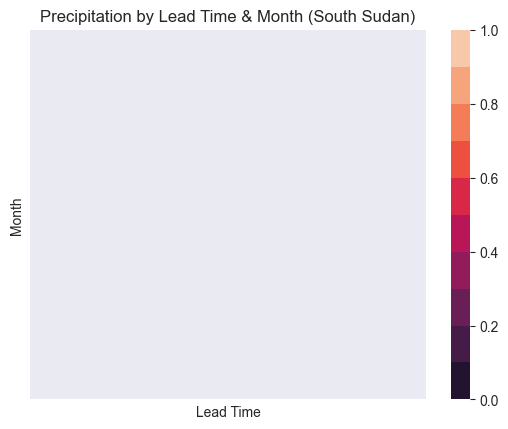

In [42]:
pivot_df = Can_ESM5_south_sudan_corr_clean.pivot_table(index = 'month', columns = 'lead time', values = 'predicted precip')
colormap = sns.color_palette('rocket', 10)
ax = sns.heatmap(pivot_df, vmin=0, vmax=1, cmap = colormap)
ax.invert_yaxis()
plt.title("Precipitation by Lead Time & Month (South Sudan)")
plt.ylabel("Month")
plt.xlabel("Lead Time")
plt.show()

In [43]:
CanESM5_eastern_east_africa = (CanESM5.sel(Y=slice(-3.5, 8.5), X=slice(218, 230))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'})
                       .groupby(['latitude', 'longitude', 'date of prediction', 'lead time'])
                       .mean('M'))
CanESM5_eastern_east_africa['longitude'] = CanESM5_eastern_east_africa['longitude'] - 180
CanESM5_eastern_east_africa_df = CanESM5_eastern_east_africa.to_dataframe().reset_index()
CanESM5_eastern_east_africa_df['time'] = CanESM5_eastern_east_africa_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 8.5), 
                                longitude=slice(37, 51))
                      .interp_like(CanESM5_eastern_east_africa, method='nearest'))
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

CanESM5_eastern_east_africa_df_merged = CanESM5_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, on = ['latitude', 'longitude', 'time'], how = 'left')
CanESM5_eastern_east_africa_df_merged.to_csv('eastern_east_africa_CanESM5_merged.csv')
CanESM5_eastern_east_africa_df_clean = CanESM5_eastern_east_africa_df_merged.drop(['date of prediction', 'latitude', 'longitude'], axis = 1)
CanESM5_eastern_east_africa_df_clean['month'] = CanESM5_eastern_east_africa_df_clean['time'].dt.month
Can_ESM5_eastern_east_africa_corr = CanESM5_eastern_east_africa_df_clean.drop('time', axis = 1).groupby(['month', 'lead time']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=2).reset_index()
Can_ESM5_eastern_east_africa_corr_clean = Can_ESM5_eastern_east_africa_corr.drop(Can_ESM5_eastern_east_africa_corr.index[::2])
Can_ESM5_eastern_east_africa_corr_clean['predicted precip'] = np.power(Can_ESM5_eastern_east_africa_corr_clean['predicted precip'], 2)
Can_ESM5_eastern_east_africa_corr_clean

KeyboardInterrupt: 

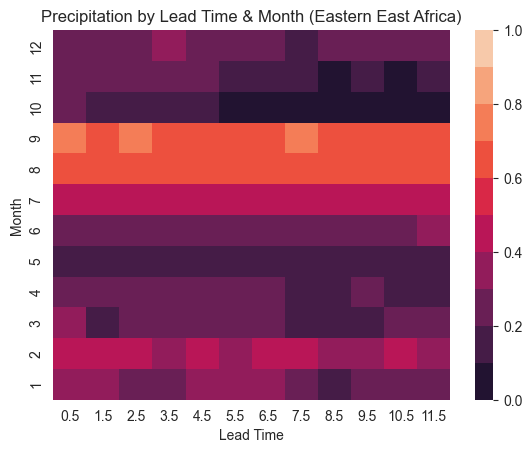

In [8]:
pivot_df = Can_ESM5_eastern_east_africa_corr_clean.pivot_table(index = 'month', columns = 'lead time', values = 'predicted precip')
colormap = sns.color_palette('rocket', 10)
ax = sns.heatmap(pivot_df, vmin=0, vmax=1, cmap = colormap)
ax.invert_yaxis()
plt.title("Precipitation by Lead Time & Month (Eastern East Africa)")
plt.ylabel("Month")
plt.xlabel("Lead Time")
plt.show()

In [9]:
CanESM5_eastern_ukraine = (CanESM5.sel(Y=slice(45, 51), X=slice(211, 220))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'})
                       .groupby(['latitude', 'longitude', 'date of prediction', 'lead time'])
                       .mean('M'))
CanESM5_eastern_ukraine['longitude'] = CanESM5_eastern_ukraine['longitude'] - 180
CanESM5_eastern_ukraine_df = CanESM5_eastern_ukraine.to_dataframe().reset_index()
CanESM5_eastern_ukraine_df['time'] = CanESM5_eastern_ukraine_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

chirps_eastern_ukraine = (chirps.sel(latitude=slice(44, 52), 
                                longitude=slice(30, 41))
                      .interp_like(CanESM5_eastern_ukraine, method='nearest'))
chirps_eastern_ukraine_df = chirps_eastern_ukraine.to_dataframe().reset_index()

CanESM5_eastern_ukraine_df_merged = CanESM5_eastern_ukraine_df.merge(chirps_eastern_ukraine_df, on = ['latitude', 'longitude', 'time'], how = 'left')
CanESM5_eastern_ukraine_df_merged.to_csv('eastern_ukraine_CanESM5_merged.csv')
CanESM5_eastern_ukraine_df_clean = CanESM5_eastern_ukraine_df_merged.drop(['date of prediction', 'latitude', 'longitude'], axis = 1)
CanESM5_eastern_ukraine_df_clean['month'] = CanESM5_eastern_ukraine_df_clean['time'].dt.month
Can_ESM5_eastern_ukraine_corr = CanESM5_eastern_ukraine_df_clean.drop('time', axis = 1).groupby(['month', 'lead time']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=2).reset_index()
Can_ESM5_eastern_ukraine_corr_clean = Can_ESM5_eastern_ukraine_corr.drop(Can_ESM5_eastern_ukraine_corr.index[::2])
Can_ESM5_eastern_ukraine_corr_clean['predicted precip'] = np.power(Can_ESM5_eastern_ukraine_corr_clean['predicted precip'], 2)
Can_ESM5_eastern_ukraine_corr_clean

,month,lead time,predicted precip
1,1,0.5,0.246412
3,1,1.5,0.010642
5,1,2.5,0.083885
7,1,3.5,0.017965
9,1,4.5,0.015540
...,...,...,...
279,12,7.5,0.006205
281,12,8.5,0.019775
283,12,9.5,0.016910
285,12,10.5,0.010034


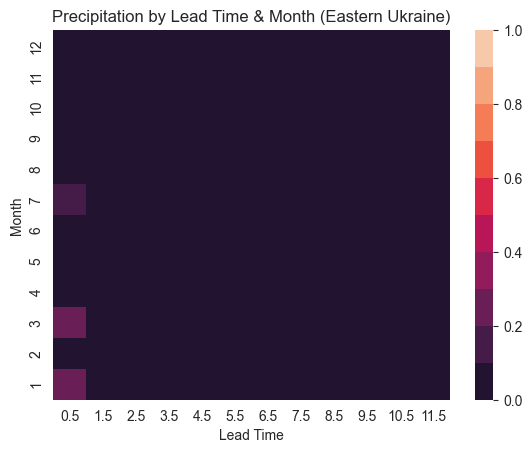

In [10]:
pivot_df = Can_ESM5_eastern_ukraine_corr_clean.pivot_table(index = 'month', columns = 'lead time', values = 'predicted precip')
colormap = sns.color_palette('rocket', 10)
ax = sns.heatmap(pivot_df, vmin=0, vmax=1, cmap = colormap)
ax.invert_yaxis()
plt.title("Precipitation by Lead Time & Month (Eastern Ukraine)")
plt.ylabel("Month")
plt.xlabel("Lead Time")
plt.show()

In [11]:
CanESM5_southern_africa = (CanESM5.sel(Y=slice(-23, -15), X=slice(205, 214))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'})
                       .groupby(['latitude', 'longitude', 'date of prediction', 'lead time'])
                       .mean('M'))
CanESM5_southern_africa['longitude'] = CanESM5_southern_africa['longitude'] - 180
CanESM5_southern_africa_df = CanESM5_southern_africa.to_dataframe().reset_index()
CanESM5_southern_africa_df['time'] = CanESM5_southern_africa_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

chirps_southern_africa = (chirps.sel(latitude=slice(-24, -14), 
                                longitude=slice(24, 35))
                      .interp_like(CanESM5_southern_africa, method='nearest'))
chirps_southern_africa_df = chirps_southern_africa.to_dataframe().reset_index()

CanESM5_southern_africa_df_merged = CanESM5_southern_africa_df.merge(chirps_southern_africa_df, on = ['latitude', 'longitude', 'time'], how = 'left')
CanESM5_southern_africa_df_merged.to_csv('southern_africa_CanESM5_merged.csv')
CanESM5_southern_africa_df_clean = CanESM5_southern_africa_df_merged.drop(['date of prediction', 'latitude', 'longitude'], axis = 1)
CanESM5_southern_africa_df_clean['month'] = CanESM5_southern_africa_df_clean['time'].dt.month
Can_ESM5_southern_africa_corr = CanESM5_southern_africa_df_clean.drop('time', axis = 1).groupby(['month', 'lead time']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=2).reset_index()
Can_ESM5_southern_africa_corr_clean = Can_ESM5_southern_africa_corr.drop(Can_ESM5_southern_africa_corr.index[::2])
Can_ESM5_southern_africa_corr_clean['predicted precip'] = np.power(Can_ESM5_southern_africa_corr_clean['predicted precip'], 2)
Can_ESM5_southern_africa_corr_clean

,month,lead time,predicted precip
1,1,0.5,0.200036
3,1,1.5,0.171327
5,1,2.5,0.179402
7,1,3.5,0.205616
9,1,4.5,0.104850
...,...,...,...
279,12,7.5,0.088734
281,12,8.5,0.096034
283,12,9.5,0.080048
285,12,10.5,0.094208


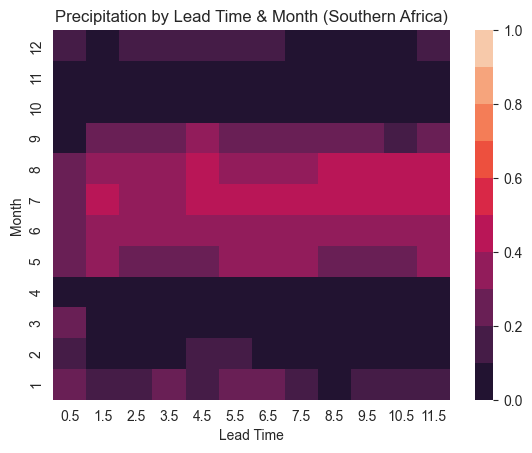

In [12]:
pivot_df = Can_ESM5_southern_africa_corr_clean.pivot_table(index = 'month', columns = 'lead time', values = 'predicted precip')
colormap = sns.color_palette('rocket', 10)
ax = sns.heatmap(pivot_df, vmin=0, vmax=1, cmap = colormap)
ax.invert_yaxis()
plt.title("Precipitation by Lead Time & Month (Southern Africa)")
plt.ylabel("Month")
plt.xlabel("Lead Time")
plt.show()

In [17]:
CanESM5_west_africa = (CanESM5.sel(Y=slice(10, 13.5), X=slice(170, 180))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'})
                       .groupby(['latitude', 'longitude', 'date of prediction', 'lead time'])
                       .mean('M'))
CanESM5_west_africa['longitude'] = CanESM5_west_africa['longitude'] - 180
CanESM5_west_africa_df = CanESM5_west_africa.to_dataframe().reset_index()
CanESM5_west_africa_df['time'] = CanESM5_west_africa_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

chirps_west_africa = (chirps.sel(latitude=slice(9, 13.5), 
                                longitude=slice(-11, 1))
                      .interp_like(CanESM5_west_africa, method='nearest'))
chirps_west_africa_df = chirps_west_africa.to_dataframe().reset_index()

CanESM5_west_africa_df_merged = CanESM5_west_africa_df.merge(chirps_west_africa_df, on = ['latitude', 'longitude', 'time'], how = 'left')
CanESM5_west_africa_df_merged.to_csv('west_africa_CanESM5_merged.csv')
CanESM5_west_africa_df_clean = CanESM5_west_africa_df_merged.drop(['date of prediction', 'latitude', 'longitude'], axis = 1)
CanESM5_west_africa_df_clean['month'] = CanESM5_west_africa_df_clean['time'].dt.month
Can_ESM5_west_africa_corr = CanESM5_west_africa_df_clean.drop('time', axis = 1).groupby(['month', 'lead time']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=2).reset_index()
Can_ESM5_west_africa_corr_clean = Can_ESM5_west_africa_corr.drop(Can_ESM5_west_africa_corr.index[::2])
Can_ESM5_west_africa_corr_clean['predicted precip'] = np.power(Can_ESM5_west_africa_corr_clean['predicted precip'], 2)
Can_ESM5_west_africa_corr_clean

,month,lead time,predicted precip
1,1,0.5,NaN
3,1,1.5,NaN
5,1,2.5,NaN
7,1,3.5,NaN
9,1,4.5,NaN
...,...,...,...
279,12,7.5,NaN
281,12,8.5,NaN
283,12,9.5,NaN
285,12,10.5,NaN


C:\Users\Johnson Leung\PycharmProjects\PSTAT Capstone\.venv\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\Users\Johnson Leung\PycharmProjects\PSTAT Capstone\.venv\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


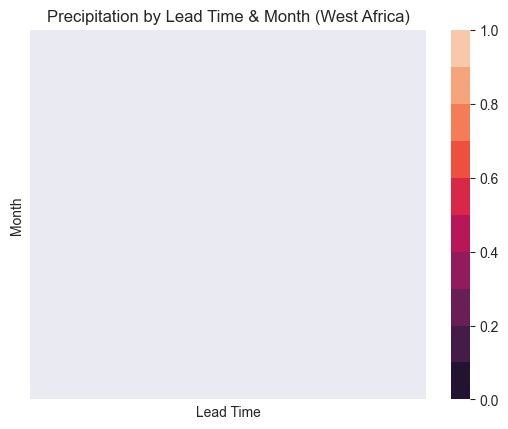

In [14]:
pivot_df = Can_ESM5_west_africa_corr_clean.pivot_table(index = 'month', columns = 'lead time', values = 'predicted precip')
colormap = sns.color_palette('rocket', 10)
ax = sns.heatmap(pivot_df, vmin=0, vmax=1, cmap = colormap)
ax.invert_yaxis()
plt.title("Precipitation by Lead Time & Month (West Africa)")
plt.ylabel("Month")
plt.xlabel("Lead Time")
plt.show()

In [47]:
CanESM5_sri_lanka = (CanESM5.sel(Y=slice(5.5, 10), X=slice(259.5, 262))
                       .rename({'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'})
                       .groupby(['latitude', 'longitude', 'date of prediction', 'lead time'])
                       .mean('M'))
CanESM5_sri_lanka['longitude'] = CanESM5_sri_lanka['longitude'] - 180
CanESM5_sri_lanka_df = CanESM5_sri_lanka.to_dataframe().reset_index()
CanESM5_sri_lanka_df['time'] = CanESM5_sri_lanka_df.apply(lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

chirps_sri_lanka = (chirps.sel(latitude=slice(5.5, 11), 
                                longitude=slice(79.5, 83))
                      .interp_like(CanESM5_sri_lanka, method='nearest'))
chirps_sri_lanka_df = chirps_sri_lanka.to_dataframe().reset_index()

CanESM5_sri_lanka_df_merged = CanESM5_sri_lanka_df.merge(chirps_sri_lanka_df, on = ['latitude', 'longitude', 'time'], how = 'left')
CanESM5_sri_lanka_df_merged.to_csv('sri_lanka_CanESM5_merged.csv')
CanESM5_sri_lanka_df_clean = CanESM5_sri_lanka_df_merged.drop(['date of prediction', 'latitude', 'longitude'], axis = 1)
CanESM5_sri_lanka_df_clean['month'] = CanESM5_sri_lanka_df_clean['time'].dt.month
Can_ESM5_sri_lanka_corr = CanESM5_sri_lanka_df_clean.drop('time', axis = 1).groupby(['month', 'lead time']).corr(method='pearson').drop('precip', axis = 1).droplevel(level=2).reset_index()
Can_ESM5_sri_lanka_corr_clean = Can_ESM5_sri_lanka_corr.drop(Can_ESM5_sri_lanka_corr.index[::2])
Can_ESM5_sri_lanka_corr_clean['predicted precip'] = np.power(Can_ESM5_sri_lanka_corr_clean['predicted precip'], 2)
Can_ESM5_sri_lanka_corr_clean

,month,lead time,predicted precip
1,1,0.5,0.027407
3,1,1.5,0.030606
5,1,2.5,0.004134
7,1,3.5,0.003415
9,1,4.5,0.017381
...,...,...,...
279,12,7.5,0.012479
281,12,8.5,0.001583
283,12,9.5,0.029369
285,12,10.5,0.007350


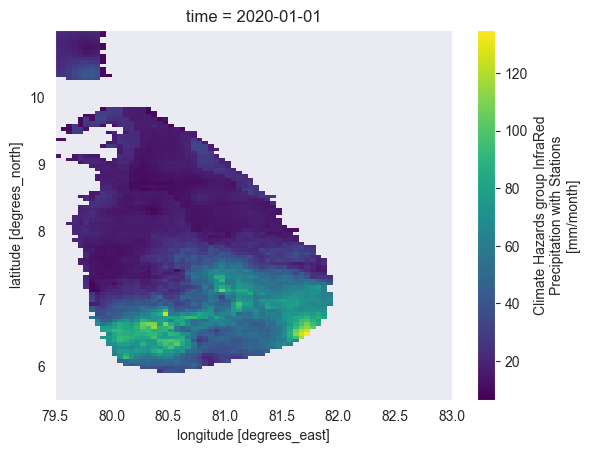

In [53]:
test = chirps_sri_lanka.sel(time = '2020-01')
test['precip'].plot()

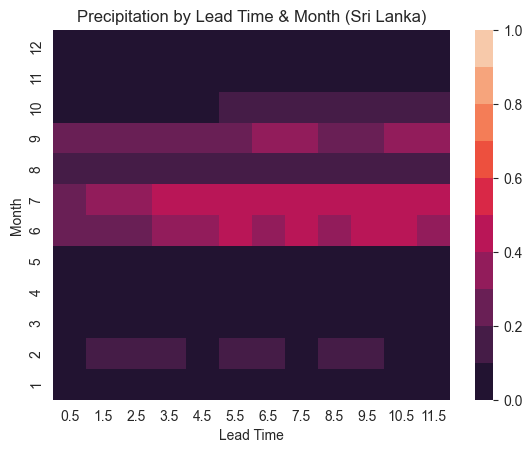

In [54]:
pivot_df = Can_ESM5_sri_lanka_corr_clean.pivot_table(index = 'month', columns = 'lead time', values = 'predicted precip')
colormap = sns.color_palette('rocket', 10)
ax = sns.heatmap(pivot_df, vmin=0, vmax=1, cmap = colormap)
ax.invert_yaxis()
plt.title("Precipitation by Lead Time & Month (Sri Lanka)")
plt.ylabel("Month")
plt.xlabel("Lead Time")
plt.show()